In [1]:
#导包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LinearRegression,ElasticNet,BayesianRidge
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression as lr
from sklearn.kernel_ridge import KernelRidge as kr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore') #消除warning

In [2]:
train = pd.read_csv("happiness_train_complete.csv", parse_dates=['survey_time'],encoding='latin-1') #survey_time，将字符串转为时间格式
test = pd.read_csv("happiness_test_complete.csv", parse_dates=['survey_time'],encoding='latin-1') #latin-1向下兼容ASCII
train = train[train["happiness"]!=-8].reset_index(drop=True)
train_data_copy = train.copy() #删去"happiness" 为-8的行
target_col = "happiness" #目标列
target = train_data_copy[target_col]
del train_data_copy[target_col] #去除目标列
data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)#参数 pd.concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
#objs 需要连接的对象，eg [df1, df2],axis = 0, 表示在水平方向(row)进行连接 axis = 1, 表示在垂直方向(column)进行连接,ignore_index 忽略需要连接的frame本身的index。当原本的index没有特别意义的时候可以使用

In [3]:
train.happiness.describe() #数据的基本信息

count    7988.000000
mean        3.867927
std         0.818717
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: happiness, dtype: float64

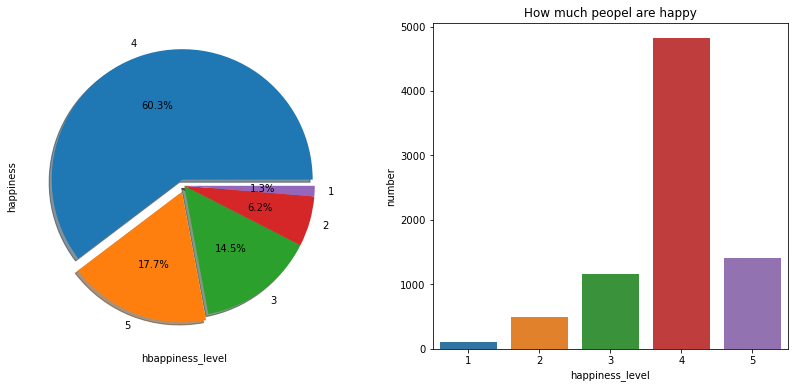

In [4]:
#描绘五个等级的占比图
f,ax=plt.subplots(1,2,figsize=(14,6))
#部分分离开
explode=(0.05,0.05,0,0,0)
train['happiness'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,explode=explode)
ax[0].set_xlabel('hbappiness_level')
#用seaborn的统计图
sns.countplot('happiness',data=train,ax=ax[1])
ax[1].set_title('How much peopel are happy',fontsize=12)
ax[1].set_xlabel('happiness_level')
ax[1].set_ylabel('number')
plt.show()

Text(0.5, 1.0, 'The correlation between features by heatmap')

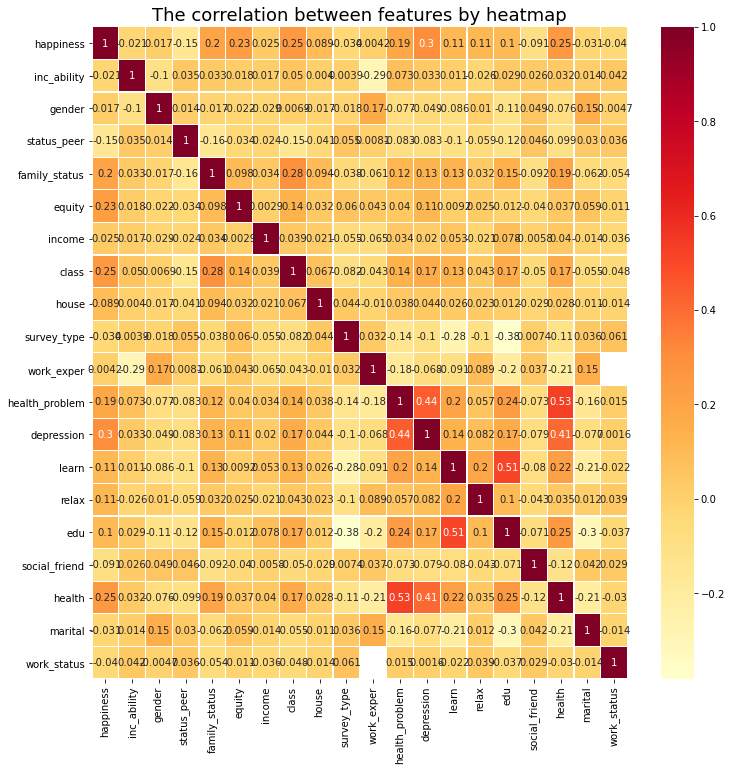

In [5]:
sns.heatmap(train[['happiness','inc_ability','gender','status_peer','family_status','equity','income','class','house','survey_type', 
                 'work_exper','health_problem','depression','learn','relax','edu','social_friend','health','marital','work_status']].corr(),
            annot=True,cmap='YlOrRd',linewidths=0.2)
fig=plt.gcf()#获取当前的figure
fig.set_size_inches(12,12)#设置尺寸
plt.title('The correlation between features by heatmap',fontsize=18)

In [6]:
#make feature +5
#csv中有复数值：-1、-2、-3、-8，将他们视为有问题的特征，但是不删去
#我们可以在 for 语句后面跟上一个 if 判断语句，用于过滤掉那些不满足条件的结果项。
def getres1(row):
    return len([x for x in row.values if type(x)==int and x<0])

def getres2(row):
    return len([x for x in row.values if type(x)==int and x==-8])

def getres3(row):
    return len([x for x in row.values if type(x)==int and x==-1])

def getres4(row):
    return len([x for x in row.values if type(x)==int and x==-2])

def getres5(row):
    return len([x for x in row.values if type(x)==int and x==-3])
#检查数据
data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
#lambda函数也叫匿名函数，即没有具体名称的函数，它允许快速定义单行函数，
#Python中apply函数的格式为：apply(func,*args,**kwargs)当然，func可以是匿名函数。
#用途：当一个函数的参数存在于一个元组或者一个字典中时，用来间接的调用这个函数，并将元组或者字典中的参数按照顺序传递给参数
data.loc[data['neg1']>20,'neg1'] = 20  #平滑处理,data.loc使用.loc[ ]第一个参数是行索引，第二个参数是列索引
data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)

In [7]:
#填充缺失值，在这里我采取的方式是将缺失值补全，使用fillna(value)，其中value的数值根据具体的情况来确定。例如将大部分缺失信息认为是零，将家庭成员数认为是1，将家庭收入这个特征认为是66365，即所有家庭的收入平均值
#填充缺失值 共25列 去掉4列 填充21列
#以下的列都是缺省的，视情况填补
data['work_status'] = data['work_status'].fillna(0)
data['work_yr'] = data['work_yr'].fillna(0)
data['work_manage'] = data['work_manage'].fillna(0)
data['work_type'] = data['work_type'].fillna(0)

data['edu_yr'] = data['edu_yr'].fillna(0)
data['edu_status'] = data['edu_status'].fillna(0)

data['s_work_type'] = data['s_work_type'].fillna(0)
data['s_work_status'] = data['s_work_status'].fillna(0)
data['s_political'] = data['s_political'].fillna(0)
data['s_hukou'] = data['s_hukou'].fillna(0)
data['s_income'] = data['s_income'].fillna(0)
data['s_birth'] = data['s_birth'].fillna(0)
data['s_edu'] = data['s_edu'].fillna(0)
data['s_work_exper'] = data['s_work_exper'].fillna(0)

data['minor_child'] = data['minor_child'].fillna(0)
data['marital_now'] = data['marital_now'].fillna(0)
data['marital_1st'] = data['marital_1st'].fillna(0)
data['social_neighbor']=data['social_neighbor'].fillna(0)
data['social_friend']=data['social_friend'].fillna(0)
data['hukou_loc']=data['hukou_loc'].fillna(1) #最少为1，表示户口
data['family_income']=data['family_income'].fillna(66365) #删除问题值后的平均值

In [8]:
#144+1 =145
#继续进行特殊的列进行数据处理
#读happiness_index.xlsx
data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y-%m-%d',errors='coerce')#防止时间格式不同的报错errors='coerce‘
data['survey_time'] = data['survey_time'].dt.year #仅仅是year，方便计算年龄
data['age'] = data['survey_time']-data['birth']
# print(data['age'],data['survey_time'],data['birth'])
#年龄分层 145+1=146
bins = [0,17,26,34,50,63,100]
data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5]) #年龄段0—17为0，17—26为1，以此类推

In [9]:
#在这里因为家庭的收入是连续值，所以不能再使用取众数的方法进行处理，这里就直接使用了均值进行缺失值的补全。第三种方法是使用我们日常生活中的真实情况，例如“宗教信息”特征为负数的认为是“不信仰宗教”，并认为“参加宗教活动的频率”为1，即没有参加过宗教活动，主观的进行补全，这也是我在这一步骤中使用最多的一种方式。
data.loc[data['religion']<0,'religion']=1
data.loc[data['religion_freq']<0,'religion_freq']=1#为从来没有参加过
#对‘教育程度’处理
data.loc[data['edu']<0,'edu'] = 4 #初中
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['edu_yr']<0,'edu_yr'] = 0
#对‘个人收入’处理
data.loc[data['income']<0,'income'] = 0 #认为无收入
#对‘政治面貌’处理
data.loc[data['political']<0,'political'] = 1 #认为是群众
#对体重处理
data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2  #个人的想法，哈哈哈，没有60斤的成年人吧
#对身高处理
data.loc[data['height_cm']<150,'height_cm'] = 150 #成年人的实际情况
#对‘健康’处理
data.loc[data['health']<0,'health'] = 4 #认为是比较健康
data.loc[data['health_problem']<0,'health_problem'] = 4
#对‘沮丧’处理
data.loc[data['depression']<0,'depression'] = 4 #一般人都是很少吧
#对‘媒体’处理
data.loc[data['media_1']<0,'media_1'] = 1 #都是从不
data.loc[data['media_2']<0,'media_2'] = 1
data.loc[data['media_3']<0,'media_3'] = 1
data.loc[data['media_4']<0,'media_4'] = 1
data.loc[data['media_5']<0,'media_5'] = 1
data.loc[data['media_6']<0,'media_6'] = 1
#对‘空闲活动’处理
data.loc[data['leisure_1']<0,'leisure_1'] = 1 #都是根据自己的想法
data.loc[data['leisure_2']<0,'leisure_2'] = 5
data.loc[data['leisure_3']<0,'leisure_3'] = 3

In [10]:
#使用众数（代码中使用mode()来实现异常值的修正），由于这里的特征是空闲活动，所以采用众数对于缺失值进行处理比较合理。
data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode() #取众数
data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()
data.loc[data['socialize']<0,'socialize'] = 2 #很少
data.loc[data['relax']<0,'relax'] = 4 #经常
data.loc[data['learn']<0,'learn'] =3#从不
#对‘社交’处理
data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
data.loc[data['social_friend']<0,'social_friend'] = 0
data.loc[data['socia_outing']<0,'socia_outing'] = 1
data.loc[data['neighbor_familiarity']<0,'social_neighbor']= 4
#对‘社会公平性’处理
data.loc[data['equity']<0,'equity'] = 4
#对‘社会等级’处理
data.loc[data['class_10_before']<0,'class_10_before'] = 3
data.loc[data['class']<0,'class'] = 5
data.loc[data['class_10_after']<0,'class_10_after'] = 5
data.loc[data['class_14']<0,'class_14'] = 2
#对‘工作情况’处理
data.loc[data['work_status']<0,'work_status'] = 0
data.loc[data['work_yr']<0,'work_yr'] = 0
data.loc[data['work_manage']<0,'work_manage'] = 0
data.loc[data['work_type']<0,'work_type'] = 0
#对‘社会保障’处理
data.loc[data['insur_1']<0,'insur_1'] = 1
data.loc[data['insur_2']<0,'insur_2'] = 1
data.loc[data['insur_3']<0,'insur_3'] = 1
data.loc[data['insur_4']<0,'insur_4'] = 1
data.loc[data['insur_1']==0,'insur_1'] = 0
data.loc[data['insur_2']==0,'insur_2'] = 0
data.loc[data['insur_3']==0,'insur_3'] = 0
data.loc[data['insur_4']==0,'insur_4'] = 0

In [11]:
#取均值进行缺失值的补全（代码实现为means()），在这里因为家庭的收入是连续值，所以不能再使用取众数的方法进行处理，这里就直接使用了均值进行缺失值的补全。
#对家庭情况处理
family_income_mean = data['family_income'].mean()
data.loc[data['family_income']<0,'family_income'] = family_income_mean
data.loc[data['family_m']<0,'family_m'] = 2
data.loc[data['family_status']<0,'family_status'] = 3
data.loc[data['house']<0,'house'] = 1
data.loc[data['car']<0,'car'] = 0
data.loc[data['car']==2,'car'] = 0 #变为0和1
data.loc[data['son']<0,'son'] = 1
data.loc[data['daughter']<0,'daughter'] = 0
data.loc[data['minor_child']<0,'minor_child'] = 0
#对‘婚姻’处理
data.loc[data['marital_1st']<0,'marital_1st'] = 0
data.loc[data['marital_now']<0,'marital_now'] = 0
#对‘配偶’处理
data.loc[data['s_birth']<0,'s_birth'] = 0
data.loc[data['s_edu']<0,'s_edu'] = 0
data.loc[data['s_political']<0,'s_political'] = 0
data.loc[data['s_hukou']<0,'s_hukou'] = 0
data.loc[data['s_income']<0,'s_income'] = 0
data.loc[data['s_work_type']<0,'s_work_type'] = 0
data.loc[data['s_work_status']<0,'s_work_status'] = 0
data.loc[data['s_work_exper']<0,'s_work_exper'] = 0
#对‘父母情况’处理
data.loc[data['f_birth']<0,'f_birth'] = 1945
data.loc[data['f_edu']<0,'f_edu'] = 1
data.loc[data['f_political']<0,'f_political'] = 1
data.loc[data['f_work_14']<0,'f_work_14'] = 2
data.loc[data['m_birth']<0,'m_birth'] = 1940
data.loc[data['m_edu']<0,'m_edu'] = 1
data.loc[data['m_political']<0,'m_political'] = 1
data.loc[data['m_work_14']<0,'m_work_14'] = 2
#和同龄人相比社会经济地位
data.loc[data['status_peer']<0,'status_peer'] = 2
#和3年前比社会经济地位
data.loc[data['status_3_before']<0,'status_3_before'] = 2
#对‘观点’处理
data.loc[data['view']<0,'view'] = 4
#对期望年收入处理
data.loc[data['inc_ability']<=0,'inc_ability']= 2
inc_exp_mean = data['inc_exp'].mean()
data.loc[data['inc_exp']<=0,'inc_exp']= inc_exp_mean #取均值

#部分特征处理，取众数（首先去除缺失值的数据）
for i in range(1,9+1):
    data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] = data['public_service_'+str(i)].dropna().mode()
for i in range(1,13+1):
    data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = data['trust_'+str(i)].dropna().mode()

In [12]:
print('shape',data.shape)

shape (10956, 146)


In [13]:
#第一次结婚年龄 147
data['marital_1stbir'] = data['marital_1st'] - data['birth'] 
#最近结婚年龄 148
data['marital_nowtbir'] = data['marital_now'] - data['birth'] 
#是否再婚 149
data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']
#配偶年龄 150
data['marital_sbir'] = data['marital_now']-data['s_birth']
#配偶年龄差 151
data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 

#收入比 151+7 =158
data['income/s_income'] = data['income']/(data['s_income']+1) #同居伴侣
data['income+s_income'] = data['income']+(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)
data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
data['income/m'] = data['income']/(data['family_m']+0.01)

#收入/面积比 158+4=162
data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

#class 162+3=165
data['class_10_diff'] = (data['class_10_after'] - data['class'])
data['class_diff'] = data['class'] - data['class_10_before']
data['class_14_diff'] = data['class'] - data['class_14']
#悠闲指数 166
leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew

#满意指数 167
public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

#信任指数 168
trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew

#province mean 168+13=181
data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

#city   mean 181+13=194
data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values #按照city分组
data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values

#county  mean 194 + 13 = 207
data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

#ratio 相比同省 207 + 13 =220
data['income/province'] = data['income']/(data['province_income_mean'])                                      
data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])   
data['equity/province'] = data['equity']/(data['province_equity_mean'])       
data['depression/province'] = data['depression']/(data['province_depression_mean'])                                                
data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
data['health/province'] = data['health']/(data['province_health_mean'])
data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
data['class/province'] = data['class']/(data['province_class_mean'])
data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)

#ratio 相比同市 220 + 13 =233
data['income/city'] = data['income']/(data['city_income_mean'])                                      
data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])   
data['equity/city'] = data['equity']/(data['city_equity_mean'])       
data['depression/city'] = data['depression']/(data['city_depression_mean'])                                                
data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
data['health/city'] = data['health']/(data['city_health_mean'])
data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
data['class/city'] = data['class']/(data['city_class_mean'])
data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])

#ratio 相比同个地区 233 + 13 =246
data['income/county'] = data['income']/(data['county_income_mean'])                                      
data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])   
data['equity/county'] = data['equity']/(data['county_equity_mean'])       
data['depression/county'] = data['depression']/(data['county_depression_mean'])                                                
data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
data['health/county'] = data['health']/(data['county_health_mean'])
data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
data['class/county'] = data['class']/(data['county_class_mean'])
data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])

#age   mean 246+ 13 =259
data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values

# 和同龄人相比259 + 13 =272
data['income/age'] = data['income']/(data['age_income_mean'])                                      
data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])   
data['equity/age'] = data['equity']/(data['age_equity_mean'])       
data['depression/age'] = data['depression']/(data['age_depression_mean'])                                                
data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
data['health/age'] = data['health']/(data['age_health_mean'])
data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
data['class/age'] = data['class']/(data['age_class_mean'])
data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])

In [14]:
print('shape',data.shape)
data.head()

shape (10956, 272)


,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,depression/age,floor_area/age,health/age,class_10_diff/age,class/age,health_problem/age,family_status/age,leisure_sum/age,public_service_sum/age,trust_sum/age
0,1,1,12,32,59,2015,1,1959,1,1,...,1.285211,0.410351,0.848837,0.000000,0.683307,0.521429,0.733668,0.724620,0.690043,0.859802
1,2,2,18,52,85,2015,1,1992,1,1,...,0.733333,0.952824,1.179337,1.012552,1.344444,0.891344,1.359551,1.011792,1.165637,1.099535
2,3,2,29,83,126,2015,2,1967,1,0,...,1.343537,0.972328,1.150485,1.190955,1.195762,1.055679,1.190955,0.966470,1.233672,0.926609
3,4,2,10,28,51,2015,2,1943,1,1,...,1.111663,0.642329,1.276353,4.977778,1.199143,1.188329,1.162630,0.899346,1.251525,1.193798
4,5,1,7,18,36,2015,2,1994,1,1,...,0.750000,0.587284,1.177106,0.000000,0.236957,1.116803,1.093645,1.045313,0.755994,1.054066


In [15]:
#数据划分和one-hot编码
#删除数值特别少的和之前用过的特征
del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
use_feature = [clo for clo in data.columns if clo not in del_list]
data.fillna(0,inplace=True) #还是补0
train_shape = train.shape[0] #一共的数据量，训练集
features = data[use_feature].columns #删除后所有的特征

X_train_263 = data[:train_shape][use_feature].values
y_train = target
X_test_263 = data[train_shape:][use_feature].values
X_train_263.shape #最终一共263个特征

(7988, 263)

In [16]:
imp_fea_49 = ['equity','depression','health','class','family_status','health_problem','class_10_after',
           'equity/province','equity/city','equity/county',
           'depression/province','depression/city','depression/county',
           'health/province','health/city','health/county',
           'class/province','class/city','class/county',
           'family_status/province','family_status/city','family_status/county',
           'family_income/province','family_income/city','family_income/county',
           'floor_area/province','floor_area/city','floor_area/county',
           'leisure_sum/province','leisure_sum/city','leisure_sum/county',
           'public_service_sum/province','public_service_sum/city','public_service_sum/county',
           'trust_sum/province','trust_sum/city','trust_sum/county',
           'income/m','public_service_sum','class_diff','status_3_before','age_income_mean','age_floor_area_mean',
           'weight_jin','height_cm',
           'health/age','depression/age','equity/age','leisure_sum/age'
          ]
train_shape=train.shape[0]
X_train_49=data[:train_shape][imp_fea_49].values
X_test_49=data[train_shape:][imp_fea_49].values
X_train_49.shape #最重要的49个特征

(7988, 49)

In [17]:
cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
           'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
           'm_political','m_work_14'] #已经是0、1的值不需要onehot

noc_fea = [clo for clo in use_feature if clo not in cat_fea]

onehot_data=data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories='auto')
#①categories='auto’时，编码时特征的取值取决于你输入编码数据的特征取值，两者的取值范围是一致的。
#②categories取值为list时，编码时特征的取值为你输入的list(eg:list_features)的取值。len(list_features)等于特征的数量，list_features中每个元素(eg:list_feature_values)又是一个list，这个list里面的元素为特征取值的所有枚举，list_feature_values=[feature_values_1,……，feature_values_n]，feature_values_n是这个特征的某种取值。
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape

X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape #其中的训练集

X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])#先是noc，再是cat_fea
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape
#print(oh_data.shape) #变为onehot编码格式
print(enc.get_feature_names())

['x0_1.0' 'x0_2.0' 'x1_1.0' 'x1_2.0' 'x2_-8.0' 'x2_1.0' 'x2_2.0' 'x2_3.0'
 'x2_4.0' 'x2_5.0' 'x2_6.0' 'x2_7.0' 'x2_8.0' 'x3_0.0' 'x3_1.0' 'x3_2.0'
 'x3_3.0' 'x3_4.0' 'x4_1.0' 'x4_2.0' 'x4_3.0' 'x4_4.0' 'x5_1.0' 'x5_2.0'
 'x5_3.0' 'x5_4.0' 'x5_5.0' 'x5_6.0' 'x5_7.0' 'x5_8.0' 'x6_1.0' 'x6_2.0'
 'x6_3.0' 'x6_4.0' 'x7_1.0' 'x7_2.0' 'x7_3.0' 'x7_4.0' 'x7_5.0' 'x7_6.0'
 'x8_0.0' 'x8_1.0' 'x8_2.0' 'x8_3.0' 'x8_4.0' 'x8_5.0' 'x8_6.0' 'x8_7.0'
 'x8_8.0' 'x8_9.0' 'x9_0.0' 'x9_1.0' 'x9_2.0' 'x10_0.0' 'x10_1.0'
 'x10_2.0' 'x10_3.0' 'x10_4.0' 'x11_1.0' 'x11_2.0' 'x11_3.0' 'x11_4.0'
 'x11_5.0' 'x11_6.0' 'x11_7.0' 'x12_0.0' 'x12_1.0' 'x12_2.0' 'x12_3.0'
 'x12_4.0' 'x13_0.0' 'x13_1.0' 'x13_2.0' 'x13_3.0' 'x13_4.0' 'x13_5.0'
 'x13_6.0' 'x13_7.0' 'x13_8.0' 'x14_0.0' 'x14_1.0' 'x14_2.0' 'x14_3.0'
 'x14_4.0' 'x14_5.0' 'x14_6.0' 'x15_0.0' 'x15_1.0' 'x15_2.0' 'x15_3.0'
 'x15_4.0' 'x15_5.0' 'x15_6.0' 'x15_7.0' 'x15_8.0' 'x15_9.0' 'x16_0.0'
 'x16_1.0' 'x16_2.0' 'x17_1.0' 'x17_2.0' 'x17_3.0' 'x17_4.0' 'x18_1.0

In [18]:
#模型训练（对383维特征进行处理）
#①决策树
#调参
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
 
params = {
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'auc',
          #'nthread':4,
          'learning_rate':0.002
          }

print('数据转换')
lgb_train = lgb.Dataset(X_train_383, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test_383, target, reference=lgb_train,free_raw_data=False)

### 交叉验证(调参)
print('交叉验证')
max_auc = float('0')
best_params = {}

print("调参1：提高准确率")
for num_leaves in range(5,10,1):
    for max_depth in range(-5,10,5):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth
 
        cv_results = lgb.cv(
                            params,
                            lgb_train,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=True
                            )
            
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
            
        if mean_auc >= max_auc:
            max_auc = mean_auc
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth
if 'num_leaves' and 'max_depth' in best_params.keys():          
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']

print("调参2：降低过拟合")
for lambda_l1 in [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]:
    for lambda_l2 in [1e-5,1e-3,1e-1,0.0,0.1,0.4,0.6,0.7,0.9,1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(
                            params,
                            lgb_train,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=True
                            )
                
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
        if mean_auc >= max_auc:
            max_auc=mean_auc
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']

print(best_params)

数据转换
交叉验证
调参1：提高准确率
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014090 sec

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867783
[LightGBM] [Info] Start training from score 3.868096
[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used feat

[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise mul

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of 

[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightG

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012285 seconds.
You can set `f

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of 

[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016220 seconds.
You can set `force_col_wise=true` to remo

[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhe

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867783
[LightGBM] [Info] Start training from score 3.868096
[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used feat

[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightG

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014827 seconds.
You can set `f

[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867783
[LightGBM] [Info] Start training from score 3.868096
[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, numb

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of 

[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightG

[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhe

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867783
[LightGBM] [Info] Start training from score 3.868096
[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used feat

[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011886 seconds.
You can set `force_col_wise=true` to remo

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013577 seconds.
You can set `f

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of 

[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867783
[LightGBM] [Info] Start training from score 3.868096
[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Au

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of 

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867783
[LightGBM] [Info] Start training from score 3.868096
[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's a

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6391, number of used features: 350
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867783
[LightGBM] [Info] Start training from score 3.868096
[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used feat

[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867919
[LightGBM] [Info] Start training from score 3.867783
[LightGBM] [Info] Start training from score 3.868096
[1]	cv_agg's auc: 1 + 0
[2]	cv_agg's auc: 1 + 0
[3]	cv_agg's auc: 1 + 0
[4]	cv_agg's auc: 1 + 0
[5]	cv_agg's auc: 1 + 0
[6]	cv_agg's auc: 1 + 0
[7]	cv_agg's auc: 1 + 0
[8]	cv_agg's auc: 1 + 0
[9]	cv_agg's auc: 1 + 0
[10]	cv_agg's auc: 1 + 0
[11]	cv_agg's auc: 1 + 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of data points in the train set: 6390, number of used features: 350
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23059
[LightGBM] [Info] Number of d

In [19]:
lgb_383_param = {
'num_leaves':9, 
'min_data_in_leaf': 20, #叶子可能具有的最小记录数
'objective':'regression',
'max_depth':5 ,
'learning_rate': 0.002,
"boosting": "gbdt", #用gbdt算法
"feature_fraction": 0.2, #例如 0.18时，意味着在每次迭代中随机选择18％的参数来建树
"bagging_freq": 1,
"bagging_fraction": 0.6, #每次迭代时用的数据比例
"bagging_seed": 14,
"metric": 'mse',
"lambda_l1": 1.0,
"lambda_l2": 1.0, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)   #交叉切分：5
oof_lgb_383 = np.zeros(len(X_train_383))
predictions_lgb_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):

    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_383[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_383[val_idx], y_train[val_idx])#train:val=4:1

    
    num_round = 10000
    lgb_383 = lgb.train(lgb_383_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 800)
    oof_lgb_383[val_idx] = lgb_383.predict(X_train_383[val_idx], num_iteration=lgb_383.best_iteration)
    predictions_lgb_383 += lgb_383.predict(X_test_383, num_iteration=lgb_383.best_iteration) / folds.n_splits

print("CV score: {:<7f}".format(mean_squared_error(oof_lgb_383, target)))

fold n°1
Training until validation scores don't improve for 800 rounds
[500]	training's l2: 0.522106	valid_1's l2: 0.550843
[1000]	training's l2: 0.468577	valid_1's l2: 0.513373
[1500]	training's l2: 0.439716	valid_1's l2: 0.496843
[2000]	training's l2: 0.420025	valid_1's l2: 0.488152
[2500]	training's l2: 0.40473	valid_1's l2: 0.482996
[3000]	training's l2: 0.392141	valid_1's l2: 0.479368
[3500]	training's l2: 0.381192	valid_1's l2: 0.477057
[4000]	training's l2: 0.371375	valid_1's l2: 0.475627
[4500]	training's l2: 0.362507	valid_1's l2: 0.474346
[5000]	training's l2: 0.354179	valid_1's l2: 0.473421
[5500]	training's l2: 0.346419	valid_1's l2: 0.472903
[6000]	training's l2: 0.339082	valid_1's l2: 0.47256
[6500]	training's l2: 0.33208	valid_1's l2: 0.472216
[7000]	training's l2: 0.325364	valid_1's l2: 0.471854
[7500]	training's l2: 0.31906	valid_1's l2: 0.471776
[8000]	training's l2: 0.312937	valid_1's l2: 0.471611
[8500]	training's l2: 0.307028	valid_1's l2: 0.471491
[9000]	training'

In [20]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# from bayes_opt import BayesianOptimization

# # 步骤一：构造黑盒目标函数
# def rf_cv( min_samples_split):
#     val = cross_val_score(
#         RandomForestRegressor( min_samples_split=int(min_samples_split),
#                                random_state=985),
#         X=X_train_383, y=y_train, scoring='neg_mean_squared_error', cv=5
#     ).mean()
#     return val

# # 步骤二：确定取值空间
# pbounds = {'min_samples_split': (10,25),
#           }

# # 步骤三：构造贝叶斯优化器
# optimizer = BayesianOptimization(
#     rf_cv,  # 黑盒目标函数
#     pbounds=pbounds,  # 取值空间
#     verbose=2,  # verbose = 2 时打印全部，verbose = 1 时打印运行中发现的最大值，verbose = 0 将什么都不打印
# #     random_state=1
# )
# optimizer.maximize(  # 运行
#     init_points=10,  # 随机搜索的步数
#     n_iter=20  # 执行贝叶斯优化迭代次数
# )
# print(optimizer.res)  # 打印所有优化的结果
# print(optimizer.max)  # 最好的结果与对应的参数


In [21]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# from bayes_opt import BayesianOptimization

# # 步骤一：构造黑盒目标函数
# def rf_cv( n_estimators,min_samples_split,max_features,max_depth):
#     val = cross_val_score(
#         RandomForestRegressor( n_estimators=int(n_estimators),
#                                min_samples_split=int(min_samples_split),
#                                max_features=min(max_features,0.5),  # float
#                                max_depth=int(max_depth),
#                                random_state=985),
#         X=X_train_383, y=y_train, scoring='neg_mean_squared_error', cv=5
#     ).mean()
#     return val

# # 步骤二：确定取值空间
# pbounds = {'n_estimators': (500,2000),
#            'min_samples_split': (10,25),
#            'max_features': (0.1,0.5),
#            'max_depth': (5,15),
#           }

# # 步骤三：构造贝叶斯优化器
# optimizer = BayesianOptimization(
#     rf_cv,  # 黑盒目标函数
#     pbounds=pbounds,  # 取值空间
#     verbose=2,  # verbose = 2 时打印全部，verbose = 1 时打印运行中发现的最大值，verbose = 0 将什么都不打印
# #     random_state=1
# )
# optimizer.maximize(  # 运行
#     init_points=10,  # 随机搜索的步数
#     n_iter=20  # 执行贝叶斯优化迭代次数
# )
# print(optimizer.res)  # 打印所有优化的结果
# print(optimizer.max)  # 最好的结果与对应的参数


In [22]:
folds = KFold(n_splits=5, shuffle=True, random_state=2021)
oof_rfr_383 = np.zeros(len(X_train_383))
predictions_rfr_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    rfr_383 = RandomForestRegressor(n_estimators=1600,max_depth=9, min_samples_leaf=9, min_weight_fraction_leaf=0.0,
            max_features=0.25,verbose=1,n_jobs=-1)
    #verbose = 0 为不在标准输出流输出日志信息
    #verbose = 1 为输出进度条记录
    #verbose = 2 为每个epoch输出一行记录
    rfr_383.fit(tr_x,tr_y)
    oof_rfr_383[val_idx] = rfr_383.predict(X_train_383[val_idx])
    predictions_rfr_383 += rfr_383.predict(X_test_383) / folds.n_splits
    
print("CV score: {:7f}".format(mean_squared_error(oof_rfr_383, target)))


fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   30.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   30.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   30.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   30.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   31.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

CV score: 0.476184


[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.2s finished


In [23]:
#③xgboost调参
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
def xgb_cv(max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda,gamma):
    val = cross_val_score(estimator=XGBRegressor(max_depth=int(max_depth),
                                                 learning_rate=learning_rate,
                                                 min_child_weight=min_child_weight,
                                                 subsample=max(min(subsample, 1), 0),
                                                 colsample_bytree=max(min(colsample_bytree, 1), 0),
                                                 reg_alpha=max(reg_alpha, 0), reg_lambda=reg_lambda,gamma=gamma, objective='reg:squarederror',
                                                 booster='gbtree',
                                                 seed=888), X=X_train_383, y=y_train, scoring='neg_mean_squared_error',
                          cv=5).mean()
    return val

xgb_bo = BayesianOptimization(xgb_cv, pbounds={'max_depth': (3, 10),
                                               'learning_rate': (0.0001, 0.1),
                                               'min_child_weight': (0,10),
                                               'subsample': (0,1),
                                               'colsample_bytree': (0,1),
                                               'reg_alpha': (0,10),
                                               'reg_lambda':(0,10),
                                               'gamma': (0, 1)
                                             }
                             )
xgb_bo.maximize(n_iter=10, init_points=20)


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.038    |  0.8126   |  0.09948  |  0.01578  |  9.567    |  0.756    |  8.299    |  8.482    |  0.6283   |
|  2        | -4.72     |  0.8401   |  0.09818  |  0.005062 |  3.8      |  2.447    |  5.362    |  3.549    |  0.9699   |
|  3        | -0.4786   |  0.5021   |  0.06823  |  0.08783  |  9.497    |  8.786    |  1.208    |  1.747    |  0.4162   |
|  4        | -0.4647   |  0.5278   |  0.2241   |  0.07352  |  4.064    |  2.532    |  5.804    |  6.389    |  0.5406   |
|  5        | -0.4784   |  0.8733   |  0.08175  |  0.07105  |  8.765    |  0.5085   |  2.38     |  0.9585   |  0.6541   |
|  6        | -5.358    |  0.1332   |  0.4071   |  0.004396 |  8.297    |  6.08     |  5.46     |  6.333    |  0.3572   |
|  7        | -2.056    

In [24]:
xgb_bo.max

{'target': -0.46046308006485015,
 'params': {'colsample_bytree': 0.49704533197708745,
  'gamma': 0.2554304865225473,
  'learning_rate': 0.07871297520804829,
  'max_depth': 9.926235779331115,
  'min_child_weight': 8.341260448186624,
  'reg_alpha': 9.551064720470976,
  'reg_lambda': 8.180288246796824,
  'subsample': 0.7212285433866669}}

In [27]:
xgb_383_params = {'eta': 0.02,  #lr
              'max_depth': 9,  
              'min_child_weight':5.6,#最小叶子节点样本权重和
              'gamma':0.25, #指定节点分裂所需的最小损失函数下降值。
              'subsample': 0.72,  #控制对于每棵树，随机采样的比例
              'colsample_bytree': 0.3,  #用来控制每棵随机采样的列数的占比 (每一列是一个特征)。
              'lambda':0.07,
              'learning_rate': 0.079,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}

folds = KFold(n_splits=5, shuffle=True, random_state=2021)
oof_xgb_383 = np.zeros(len(X_train_383))
predictions_xgb_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_383[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_383[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_383 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_383_params)
    oof_xgb_383[val_idx] = xgb_383.predict(xgb.DMatrix(X_train_383[val_idx]), ntree_limit=xgb_383.best_ntree_limit)
    predictions_xgb_383 += xgb_383.predict(xgb.DMatrix(X_test_383), ntree_limit=xgb_383.best_ntree_limit) / folds.n_splits

print("CV score: {:<7f}".format(mean_squared_error(oof_xgb_383, target)))

fold n°1
[18:02:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:02:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:3.20153	valid_data-rmse:3.20628
[500]	train-rmse:0.12748	valid_data-rmse:0.70877
[661]	train-rmse:0.12399	valid_data-rmse:0.70849
fold n°2
[18:02:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:02:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_r

In [28]:
train_stack1 = np.vstack([oof_lgb_383,oof_xgb_383,oof_rfr_383]).transpose()
# transpose()函数的作用就是调换x,y,z的位置,也就是数组的索引值
test_stack1 = np.vstack([predictions_lgb_383, predictions_xgb_383,predictions_rfr_383]).transpose()

#交叉验证:5折，重复2次
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack1 = np.zeros(train_stack1.shape[0])
predictions_lr1 = np.zeros(test_stack1.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack1,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack1[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack1[val_idx], target.iloc[val_idx].values
    #Kernel Ridge Regression
    lr1 = kr()
    lr1.fit(trn_data, trn_y)
    
    oof_stack1[val_idx] = lr1.predict(val_data)
    predictions_lr1 += lr1.predict(test_stack1) / 10
    
mean_squared_error(target.values, oof_stack1) 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.45192546383897303

In [29]:
##### lgb_49
lgb_49_param = {
'num_leaves': 9,
'min_data_in_leaf': 23,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.002,
"boosting": "gbdt",
"feature_fraction": 0.45, 
"bagging_freq": 1,
"bagging_fraction": 0.65, 
"bagging_seed": 15,
"metric": 'mse',
"lambda_l2": 0.2, 
"verbosity": -1} # 一个叶子上数据的最小数量 \ feature_fraction将会在每棵树训练之前选择 45% 的特征。可以用来加速训练，可以用来处理过拟合。 #bagging_fraction不进行重采样的情况下随机选择部分数据。可以用来加速训练，可以用来处理过拟合。
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)   
oof_lgb_49 = np.zeros(len(X_train_49))
predictions_lgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_49[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_49[val_idx], y_train[val_idx])

    num_round = 12000
    lgb_49 = lgb.train(lgb_49_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof_lgb_49[val_idx] = lgb_49.predict(X_train_49[val_idx], num_iteration=lgb_49.best_iteration)
    predictions_lgb_49 += lgb_49.predict(X_test_49, num_iteration=lgb_49.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_49, target)))

fold n°1
Training until validation scores don't improve for 1000 rounds
[1000]	training's l2: 0.472114	valid_1's l2: 0.494341
[2000]	training's l2: 0.432433	valid_1's l2: 0.474187
[3000]	training's l2: 0.410225	valid_1's l2: 0.468771
[4000]	training's l2: 0.39252	valid_1's l2: 0.46653
[5000]	training's l2: 0.37695	valid_1's l2: 0.465936
[6000]	training's l2: 0.362991	valid_1's l2: 0.466085
Early stopping, best iteration is:
[5373]	training's l2: 0.371564	valid_1's l2: 0.465725
fold n°2
Training until validation scores don't improve for 1000 rounds
[1000]	training's l2: 0.471663	valid_1's l2: 0.494653
[2000]	training's l2: 0.431201	valid_1's l2: 0.475828
[3000]	training's l2: 0.408572	valid_1's l2: 0.471512
[4000]	training's l2: 0.390545	valid_1's l2: 0.470385
[5000]	training's l2: 0.375087	valid_1's l2: 0.470372
Early stopping, best iteration is:
[4456]	training's l2: 0.383242	valid_1's l2: 0.470227
fold n°3
Training until validation scores don't improve for 1000 rounds
[1000]	training

In [30]:
##### xgb_49
xgb_49_params = {'eta': 0.02, 
              'max_depth': 5, 
              'min_child_weight':3,
              'gamma':0,
              'subsample': 0.7, 
              'colsample_bytree': 0.35, 
              'lambda':2,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}


folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_49 = np.zeros(len(X_train_49))
predictions_xgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_49[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_49[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_49 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_49_params)
    oof_xgb_49[val_idx] = xgb_49.predict(xgb.DMatrix(X_train_49[val_idx]), ntree_limit=xgb_49.best_ntree_limit)
    predictions_xgb_49 += xgb_49.predict(xgb.DMatrix(X_test_49), ntree_limit=xgb_49.best_ntree_limit) / folds.n_splits

print("CV score: {:<7f}".format(mean_squared_error(oof_xgb_49, target)))

fold n°1
[18:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:3.40423	valid_data-rmse:3.38324
[500]	train-rmse:0.52685	valid_data-rmse:0.71752
[1000]	train-rmse:0.43482	valid_data-rmse:0.72012
[1178]	train-rmse:0.40613	valid_data-rmse:0.72151
fold n°2
[18:06:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:59] WARNIN

In [31]:
X = X_train_49     # 样本
y = y_train 


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbm0 = GradientBoostingClassifier(random_state=2022)
gbm0.fit(X, y)
print("score: %.4g" % mean_squared_error(y.values, gbm0.predict(X)))      

In [ ]:
# param_test1 = {'n_estimators':range(500,1500,100)}

# gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300,
#                         min_samples_leaf=20,max_depth=8,max_features='sqrt', subsample=0.8,random_state=2022),
#                         param_grid = param_test1, scoring='neg_mean_squared_error',iid=False,cv=5)
# gsearch1.fit(X, y)

# print(gsearch1.cv_results_['mean_test_score'], gsearch1.best_params_, gsearch1.best_score_)

In [ ]:
# param_test2 = {'max_depth':range(3,14,2),
#                'min_samples_split':range(100,801,200)}

# gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, min_samples_leaf=20,
#                         max_features='sqrt', subsample=0.8, random_state=2019),
#                         param_grid = param_test2, scoring='neg_mean_squared_error',iid=False, cv=5)

# gsearch2.fit(X, y)

# print(gsearch2.cv_results_['neg_mean_squared_error'], gsearch2.best_params_, gsearch2.best_score_)

In [ ]:
param_test3 = {'min_samples_split':range(800,1900,200),
               'min_samples_leaf':range(60,101,10)}

gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=7,
                        max_features='sqrt', subsample=0.8, random_state=2019),
                        param_grid = param_test3, scoring='neg_mean_squared_error',iid=False, cv=5, verbose=3)

gsearch3.fit(X, y)
print(gsearch3.cv_results_['mean_test_score'], gsearch3.best_params_, gsearch3.best_score_)

In [32]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)
oof_gbr_49 = np.zeros(train_shape)
predictions_gbr_49 = np.zeros(len(X_test_49))

#GradientBoostingRegressor梯度提升决策树
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    gbr_49 = gbr(n_estimators=600, learning_rate=0.01,subsample=0.65,max_depth=6, min_samples_leaf=70,
           min_samples_split=1200,max_features=0.35,verbose=1)
    gbr_49.fit(tr_x,tr_y)
    oof_gbr_49[val_idx] = gbr_49.predict(X_train_49[val_idx])
    
    predictions_gbr_49 += gbr_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_gbr_49, target)))

fold n°1
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6630           0.0023           33.83s
         2           0.6579           0.0028           22.83s
         3           0.6458           0.0019           16.79s
         4           0.6530           0.0022           14.20s
         5           0.6565           0.0022           12.53s
         6           0.6582           0.0020           11.32s
         7           0.6645           0.0023           10.53s
         8           0.6491           0.0019            9.86s
         9           0.6407           0.0019            9.34s
        10           0.6544           0.0018            8.98s
        20           0.6104           0.0017            7.36s
        30           0.5894           0.0015            6.64s
        40           0.6177           0.0015            6.35s
        50           0.5987           0.0010            6.11s
        60           0.5700           0.0009            5.97

In [33]:
train_stack2 = np.vstack([oof_lgb_49,oof_xgb_49,oof_gbr_49]).transpose()
test_stack2 = np.vstack([predictions_lgb_49, predictions_xgb_49,predictions_gbr_49]).transpose()
#
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack2 = np.zeros(train_stack2.shape[0])
predictions_lr2 = np.zeros(test_stack2.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack2,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack2[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack2[val_idx], target.iloc[val_idx].values
        #Kernel Ridge Regression
    lr2 = kr()
    lr2.fit(trn_data, trn_y)
    
    oof_stack2[val_idx] = lr2.predict(val_data)
    predictions_lr2 += lr2.predict(test_stack2) / 10
    
mean_squared_error(target.values, oof_stack2) 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4693552798601378

In [34]:
train_stack3 = np.vstack([oof_stack1,oof_stack2]).transpose()
test_stack3 = np.vstack([predictions_lr1, predictions_lr2]).transpose()

folds_stack = RepeatedKFold(n_splits=3, n_repeats=2, random_state=7)
oof_stack3 = np.zeros(train_stack3.shape[0])
predictions_lr3= np.zeros(test_stack3.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack3,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack3[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack3[val_idx], target.iloc[val_idx].values
    #LinearRegression
    lr3 = lr()
    lr3.fit(trn_data, trn_y)
    
    oof_stack3[val_idx] = lr3.predict(val_data)
    predictions_lr3 += lr3.predict(test_stack3) / 10
    
mean_squared_error(target.values, oof_stack3) 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5


0.45236122057494516

In [35]:
submit_example = pd.read_csv('happiness_submit.csv',sep=',',encoding='latin-1')
submit_example['happiness'] = predictions_lr3
submit_example.happiness.describe()

count    2968.000000
mean        2.328123
std         0.275629
min         0.937522
25%         2.203160
50%         2.373009
75%         2.510421
max         2.989605
Name: happiness, dtype: float64